# Google Play Store Exploratory Analysis

Dataset available on https://www.kaggle.com/lava18/google-play-store-apps

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

from os import path, getcwd
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

sns.set_theme(style='darkgrid', palette='Set3')

# Loading and checking datasets

In [2]:
df_apps = pd.read_csv('datasets/googleplaystore.csv')
df_apps.head(3)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


In [3]:
df_apps.shape

(10841, 13)

In [4]:
df_apps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [5]:
df_apps.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

In [6]:
df_reviews = pd.read_csv('datasets/googleplaystore_user_reviews.csv')
df_reviews.head(3)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN


In [7]:
df_reviews.shape

(64295, 5)

In [8]:
df_reviews.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

# Data Cleaning

## Deleting irrelevant data

In [9]:
df_apps.drop(['Last Updated', 'Current Ver'], axis=1, inplace=True)
df_apps.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,4.0.3 and up


## Dealing with missing information

### Type

* There's only 1 App without 'Type', so we'll be fixing this manually

In [10]:
df_apps[df_apps['Type'].isna()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,Varies with device


In [11]:
# Type according to Google Play Store (23/03/21)
type_column = df_apps.columns.get_loc('Type')
df_apps.iloc[9148, type_column] = 'Free'

In [12]:
df_apps['Type'].value_counts()

Free    10040
Paid      800
0           1
Name: Type, dtype: int64

* There's 1 App with 'Type' = 0. Let's take a look at it:

In [13]:
df_apps[df_apps['Type'] == '0']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",NaN


* This row values have been misplaced. We'll be fixing it:

In [14]:
df_apps.iloc[10472] = df_apps.iloc[10472].replace(['1.9', 19.0, '3.0M', '1,000+', 'Free', '0', 'Everyone', 'February 11, 2018'], ['LIFESTYLE', 1.9, '19.0', '3.0M', '1,000+', 'Free', '0', 'Lifestyle'])

version_column = df_apps.columns.get_loc('Android Ver')
df_apps.iloc[10472, version_column] = '4.0 and up'

content_rating_column = df_apps.columns.get_loc('Content Rating')
df_apps.iloc[10472, content_rating_column] = 'Everyone'

In [15]:
df_apps['Type'].value_counts()

Free    10041
Paid      800
Name: Type, dtype: int64

### Android Ver

* There are 2 Apps without 'Android Ver'. We'll be filling them with the most common Android Version

In [16]:
most_common_android = df_apps['Android Ver'].value_counts().idxmax()
df_apps['Android Ver'].fillna(most_common_android, inplace=True)

### Rating

* There are a lot of 'NaN' values in this column. 
* We'll be keeping them as 'NaN' values and analyze the 'valid' ratings separately.

In [17]:
df_apps.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Android Ver          0
dtype: int64

### Reviews

* There are a lot o 'NaN' values in the review dataset. We'll be dropping them.

In [18]:
df_reviews.dropna(inplace=True)

In [19]:
df_reviews.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [20]:
df_apps.head(1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,4.0.3 and up


## Changing data types

### Review (to numeric)

In [21]:
df_apps['Reviews'] = pd.to_numeric(df_apps['Reviews'])

### Installs (to numeric)

In [22]:
df_apps['Installs'] = df_apps['Installs'].apply(lambda x: float(x[:-1].replace(',', '')) if x[-1] == '+' else float(x))

### Size (to numeric - in kilobytes)

In [23]:
# Converts the App Size to kilobytes (Size will be 0 if 'Varies with Device')
df_apps['Size'] = df_apps['Size'].apply(lambda x: float(x[:-1])*1024 if x[-1] == 'M' else(float(x[:-1]) if x[-1] == 'k' else 0))

### Price (to numeric - in dollars)

In [24]:
df_apps['Price'] = df_apps['Price'].apply(lambda x: float(x[1:]) if x[0] == '$' else float(x))

### Android Version (remove part of the text )

In [25]:
df_apps['Android Ver'] = df_apps['Android Ver'].apply(lambda x: x.split(' ')[0])

### Rename column

In [26]:
df_apps.rename(columns={'Installs': 'Downloads'}, inplace=True)

# Visualization

In [27]:
print(f'{df_apps.shape[0]} Android Apps')

10841 Android Apps


### Most common Google Play Apps Category

* What are the most common app categories on Google Play Store?

In [28]:
print(f"There are {df_apps['Category'].unique().shape[0]} different App Categories")

There are 33 different App Categories


In [29]:
common_categories = df_apps['Category'].value_counts()

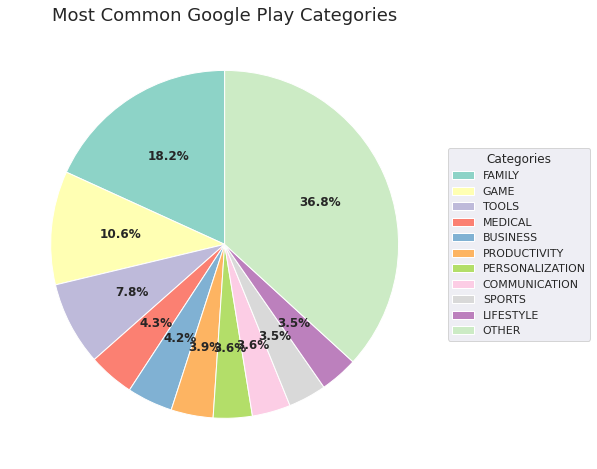

In [30]:
# Generate Labels and Values
labels = common_categories.head(10).index.tolist()
labels.append('OTHER')
values = common_categories.head(10).values.tolist()
values.append(df_apps.shape[0] - common_categories.head(10).sum())

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values, startangle=90, autopct='%1.1f%%')
ax.legend(wedges, labels,
          title='Categories',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight='bold')
ax.set_title("Most Common Google Play Categories", fontsize=18)
plt.show()

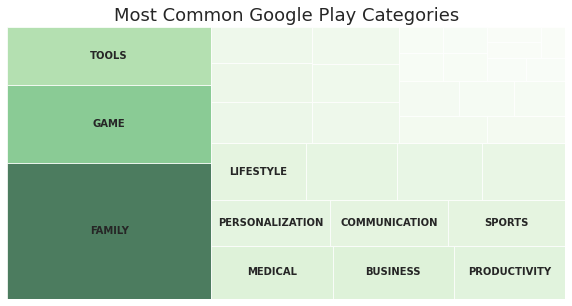

In [31]:
# Generate Labels and Values
labels = common_categories.index.tolist()
values = common_categories.values.tolist()

# Generate Colormap
cmap = matplotlib.cm.Greens
mini = min(common_categories)
maxi = max(common_categories)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in common_categories]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
squarify.plot(values, label=labels[:10], color=colors, alpha=0.7, text_kwargs={'fontsize': 10, 'weight': 'bold'})
ax.axis('off')
ax.set_title("Most Common Google Play Categories", fontsize=18)
plt.show()

* <strong>Family</strong>, <strong>Game</strong> and <strong>Tools</strong> are the most common app categories (in number of apps)

* The <strong>other</strong> 30 categories represent <strong>63.5%</strong> of the applications. But <strong>each category</strong> is responsible for <strong>less than 5%</strong> of the applications.

### Top Google Play Categories (in number of downloads)

* What are the most popular app categories on Google Play Store? (number of downloads)

In [32]:
top_categories_downloads = df_apps.groupby(['Category'])['Downloads'].sum().sort_values(ascending=False)

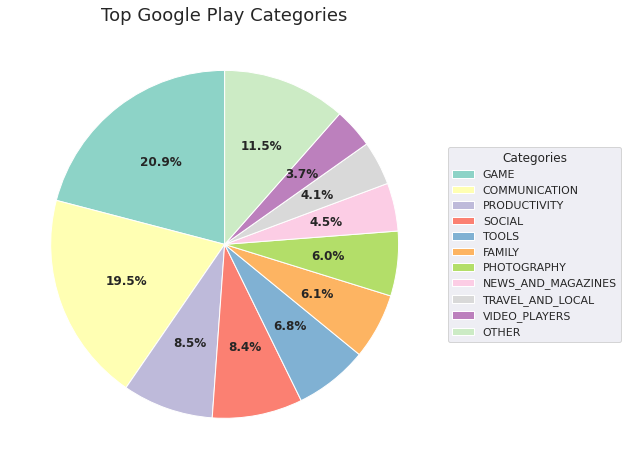

In [33]:
# Generate Labels and Values
labels_top10 = top_categories_downloads.head(10).index.tolist()
labels_top10.append('OTHER')
values_top10 = top_categories_downloads.head(10).values.tolist()
values_top10.append(df_apps['Downloads'].sum() - top_categories_downloads.head(10).sum())

# Plot
fig, ax = plt.subplots(figsize=(10,8))
wedges, text, autotexts = ax.pie(values_top10, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 12})
ax.legend(wedges, labels_top10,
          title='Categories',
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight='bold')
ax.set_title("Top Google Play Categories", fontsize=18)
plt.show()

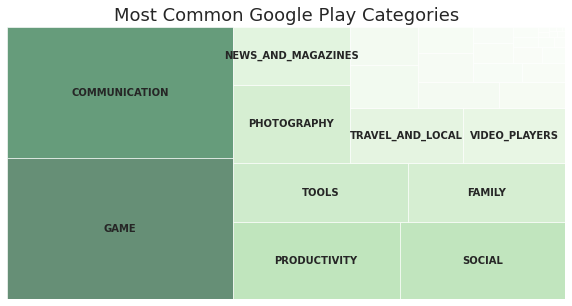

In [34]:
# Generate Labels and Values
labels = top_categories_downloads.index.tolist()
values = top_categories_downloads.values.tolist()

# Generate Colormap
cmap = matplotlib.cm.Greens
mini = min(top_categories_downloads)
maxi = max(top_categories_downloads)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(i)) for i in top_categories_downloads]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
squarify.plot(values, label=labels[:10], color=colors, alpha=0.6, text_kwargs={'fontsize': 10, 'weight': 'bold'})
ax.axis('off')
ax.set_title("Most Common Google Play Categories", fontsize=18)
plt.show()

* <strong>Game</strong> and <strong>Communication</strong> are the most popular app categories. <strong>Together</strong> they are responsible for about <strong>40% of all Google Play Store downloads</strong>.

### Rating Distribution (Overall)

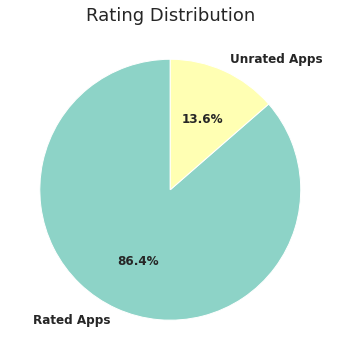

In [35]:
rated_apps = pd.DataFrame(df_apps[df_apps['Rating'].notna()])
unrated_apps = df_apps[df_apps['Rating'].isna()]

values = [rated_apps.shape[0], unrated_apps.shape[0]]
labels = ['Rated Apps', 'Unrated Apps']

fig, ax = plt.subplots(figsize=(10,6))
wedges, text, autotexts = ax.pie(values, labels=labels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 12, 'weight': 'bold'})
plt.setp(autotexts, size=12, weight='bold')
ax.set_title("Rating Distribution", fontsize=18)
plt.show()

* The <strong>majority</strong> (86.4%) of the Google Play Apps <strong>receive a user rating</strong>.

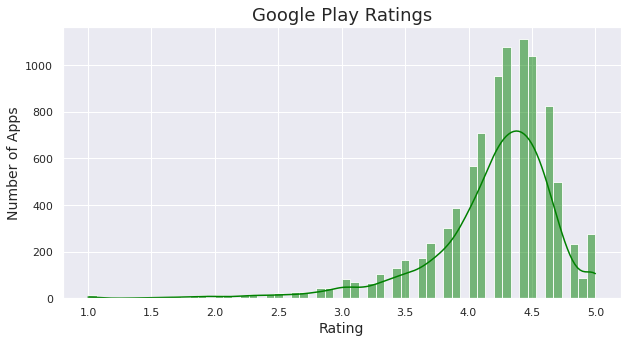

In [36]:
valid_ratings = rated_apps['Rating']

plt.figure(figsize=(10,5))
plt.title('Google Play Ratings', fontsize=18)
plt.ylabel('Number of Apps', fontsize=14)
plt.xlabel('Rating', fontsize=14)
sns.histplot(valid_ratings, kde=True, color='g', bins=60)
plt.show()

* Most of the Apps have good ratings (> 4.0)

In [37]:
print(f"The average app rating is {valid_ratings.mean():.2f}")

The average app rating is 4.19


### Rating Distribution (across the 3 most common categories)

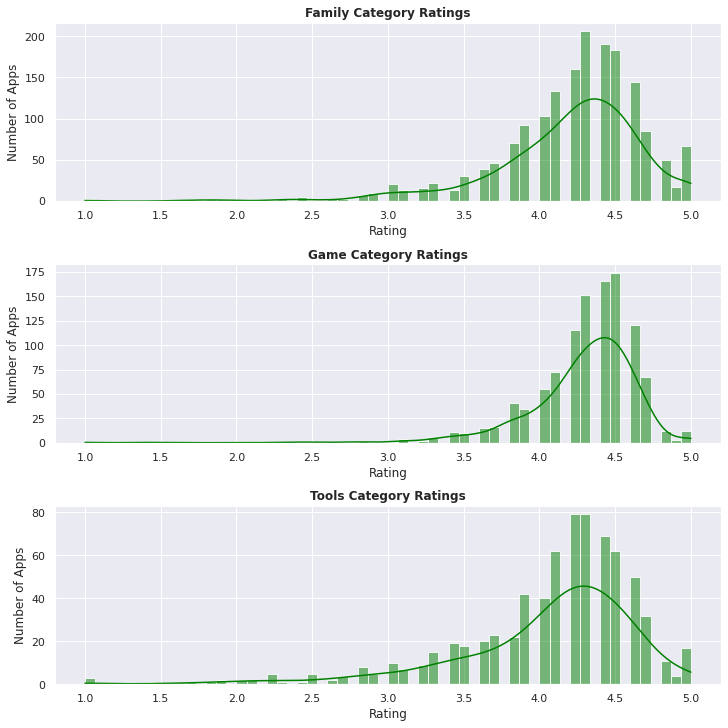

In [38]:
family_category_ratings = rated_apps[rated_apps['Category'] == 'FAMILY']['Rating']
game_category_ratings = rated_apps[rated_apps['Category'] == 'GAME']['Rating']
tools_category_ratings = rated_apps[rated_apps['Category'] == 'TOOLS']['Rating']

fig, axs = plt.subplots(3, 1, figsize=(10,10), constrained_layout=True)

sns.histplot(ax=axs[0], data=family_category_ratings, kde=True, color='g', bins=60)
axs[0].set_title('Family Category Ratings', fontweight='bold')
sns.histplot(ax=axs[1], data=game_category_ratings, kde=True, color='g', bins=60)
axs[1].set_title('Game Category Ratings', fontweight='bold')
sns.histplot(ax=axs[2], data=tools_category_ratings, kde=True, color='g', bins=60)
axs[2].set_title('Tools Category Ratings', fontweight='bold')
for i in range(3): axs[i].set_ylabel('Number of Apps')

plt.show()

* The rating distribution is similar across the 3 most common app categories

### Rating Distribution (Paid Apps x Free Apps)

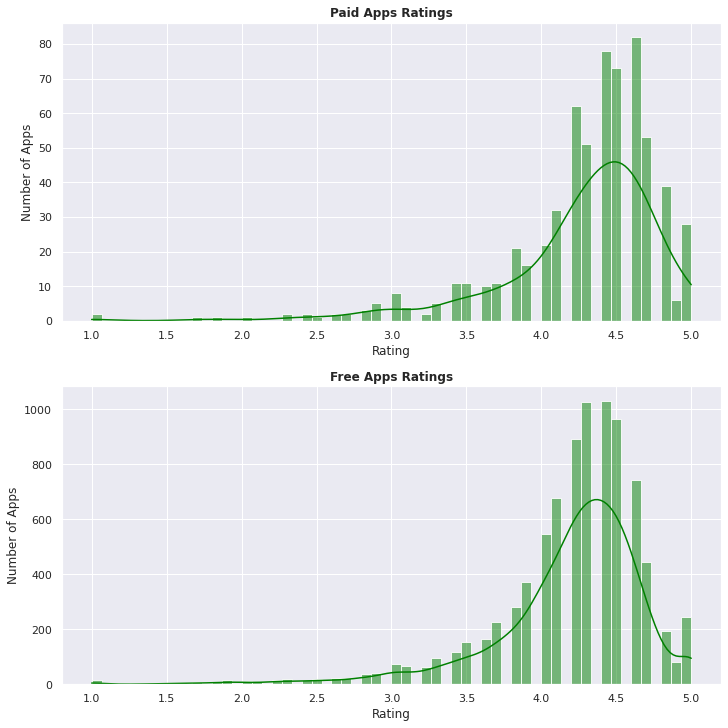

In [39]:
paid_apps_ratings = rated_apps[rated_apps['Type'] == 'Paid']['Rating']
free_apps_ratings = rated_apps[rated_apps['Type'] == 'Free']['Rating']

fig, axs = plt.subplots(2, 1, figsize=(10,10), constrained_layout=True)

sns.histplot(ax=axs[0], data=paid_apps_ratings, kde=True, color='g', bins=60)
axs[0].set_title('Paid Apps Ratings', fontweight='bold')
sns.histplot(ax=axs[1], data=free_apps_ratings, kde=True, color='g', bins=60)
axs[1].set_title('Free Apps Ratings', fontweight='bold')
for i in range(2): axs[i].set_ylabel('Number of Apps')
plt.show()

* The rating distribution is similar across Paid and Free apps

### Downloads: Paid Apps x Free Apps

### Reviews per Category

### App Size Distribution

### Number of Reviews x Number of Installs

### Most common words in reviews (Wordcloud)

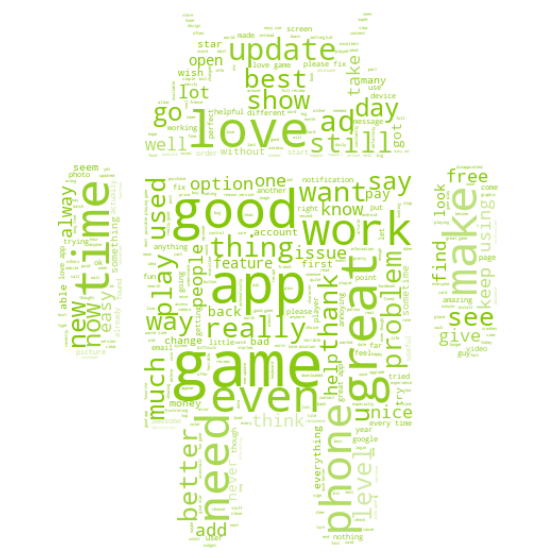

In [60]:
# Mask image config
mask = np.array(Image.open('imgs/mask-image.png'))
mask[mask==0] = 255

# Wordcloud config
text = ' '.join(df_reviews['Translated_Review']).lower()
wordcloud = WordCloud(background_color='white', max_words=400, mask=mask, stopwords=STOPWORDS, max_font_size=60, random_state=11)
wordcloud.generate(text)
image_colors = ImageColorGenerator(mask)

# Plot
plt.figure(figsize=[15,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()